In [54]:
import glob
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
import imageio   # Convert to an image 
import nibabel as nib
from PIL import Image
# import SimpleITK  as sitk

from pathlib import Path

In [2]:
from platform import python_version

print(python_version())

3.8.10


In [3]:
print("The current DIR: ", os.getcwd())
np.random.seed(1000)
torch.manual_seed(1000)

The current DIR:  /home/shsingh/knowledge_distillation/notebooks


In [4]:
def get_GPU_info():
    print(torch.cuda.max_memory_allocated())
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary()) 

    available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
    print(available_gpus)

    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name())
#     print(torch.cuda.mem_get_info(device=device))
    return

In [5]:
get_GPU_info()
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
print("DEVICE currently being used: ", device)

0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B 

In [6]:
os.getcwd()

'/home/shsingh/knowledge_distillation'

# Draft Code


## Paths

In [35]:
DATASET_DIR = Path("knowledge_distillation/dataset/scratch/")
dataset_name ="MICCAI_BraTS2020_Data"

data_dir = DATASET_DIR / dataset_name

output_dir = "MICCAI_BraTS2020_Data_npz_v2"
save_dir = DATASET_DIR /output_dir

In [13]:
print(data_dir)
print(save_dir)

knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data_npz_v2


## Function: Extract 2D-Slice for each subject
1. Read and convert **'.nii.gz'** subject data to 2D-Slices (#155/modularity)
2. Each subject has 4 modularities(t1,t1ce, t2, flair) and respective seg for each slice
3. num_subjects = **369** <br />
   num_modularities = **4** <br />
   num_2d_slices = **155 <br />
   **total:  (369x4x155)** <br />

In [32]:
    

def save_nii_to_npy(subject_data, subject_save_path):           
    if not os.path.exists(subject_save_path):        
        os.makedirs(subject_save_path)        
    subject_slice_id = subject_save_path.name
    (x,y,z) = subject_data.shape
    for i in range(z):      #z Is a sequence of images 
        silce = subject_data[:, :, i]   # You can choose which direction of slice 
        np.expand_dims(silce, axis =-1)
        np.save(os.path.join(subject_save_path,subject_slice_id+'_{}.npy'.format(i)), silce)
    return 

from sklearn.preprocessing import LabelEncoder

def save_nii_mask_to_npy(mask_file,subject_save_path):
    if not os.path.exists(subject_save_path):
        os.makedirs(subject_save_path)        
    subject_slice_id = subject_save_path.name

    mask_file[mask_file==4] = 3 
    mask = np.moveaxis(mask_file, 2,0)

    labelencoder = LabelEncoder()
    n,h,w = mask.shape
    n_classes = 4
    mask_reshape = mask.reshape(-1,1)
    mask_encoded = labelencoder.fit_transform(mask_reshape)
    mask_encoded_shape = mask_encoded.reshape(n,h,w)

    for i in range(n):
        silce = mask_encoded_shape[i,:,:]
        mask_img = np.expand_dims(silce , axis = -1)
        np.save(os.path.join(subject_save_path,subject_slice_id+ '_{}.npy'.format(i)), mask_img)
    return


subject_ids = sorted(os.listdir(data_dir))
substring_subject_id ='BraTS20_'

for subject in subject_ids:
    if substring_subject_id in subject:                        
        subject_path = data_dir / subject
        subject_modularities = sorted(os.listdir(subject_path))
        for modularity in subject_modularities:
            print("modularity: ",modularity)
            
            subject_data = nib.load(os.path.join(subject_path,modularity)).get_fdata()
            mod_name = modularity.replace('.nii.gz','')
            subject_save_path = save_dir / subject / mod_name
            if 'seg' in mod_name:
                save_nii_mask_to_npy(subject_data, subject_save_path)
            else:
                save_nii_mask_to_npy(mask_file,subject_save_path)
            
    elif subject.endsith('.csv'):
        print("No data-file found.Only .csv")
    else:
        print("Empty DIR. No '.csv/data-file present'.")

NO data-file found.
modularity:  BraTS20_Training_001_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data_npz_v2/BraTS20_Training_001/BraTS20_Training_001_flair
BraTS20_Training_001_flair
modularity:  BraTS20_Training_001_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data_npz_v2/BraTS20_Training_001/BraTS20_Training_001_seg
BraTS20_Training_001_seg
modularity:  BraTS20_Training_001_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data_npz_v2/BraTS20_Training_001/BraTS20_Training_001_t1
BraTS20_Training_001_t1
modularity:  BraTS20_Training_001_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data_npz_v2/BraTS20_Training_001/BraTS20_Training_001_t1ce
BraTS20_Training_001_t1ce
modularity:  BraTS20_Training_001_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data_npz_v2/BraTS20_Training_001/BraTS20_Training_001_t2
BraTS20_Training_001_t2
modularity:  BraTS20_Training_002_flair.nii.gz
knowledge_

KeyboardInterrupt: 

In [39]:
print(subject_save_path)
print(os.path.join(str(subject_save_path),str(subject_save_path.name)+ "_"))

knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data_npz_v2/BraTS20_Training_002/BraTS20_Training_002_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data_npz_v2/BraTS20_Training_002/BraTS20_Training_002_t1ce/BraTS20_Training_002_t1ce_


# Old draft code

In [7]:

from sklearn.preprocessing import LabelEncoder


def nii_mask_to_npy(mask_file,output_path):

    if not os.path.exists(output_path):
        os.makedirs(output_path)
    print(output_path)  
    img_name = output_path.split('/')[-1]
    print(img_name)
#     print(np.unique(mask_file))

    mask_file[mask_file==4] = 3 
    mask = np.moveaxis(mask_file, 2,0)


    labelencoder = LabelEncoder()
    n,h,w = mask.shape
    n_classes = 4

    mask_reshape = mask.reshape(-1,1)
#     print(np.shape(mask_reshape))


    mask_encoded = labelencoder.fit_transform(mask_reshape)
    mask_encoded_shape = mask_encoded.reshape(n,h,w)

    print(np.unique(mask_encoded_shape))
    for i in range(n):
        silce = mask_encoded_shape[i,:,:]
#         print("Slice shape: " ,np.shape(silce) )
        mask_img = np.expand_dims(silce , axis = -1)
        np.save(os.path.join(output_path,img_name+ '_'+ '{}.npy'.format(i)), mask_img)
#         imageio.imwrite(os.path.join(output_path,img_name+ '_'+ '{}.png'.format(i)), mask_img)

    return


In [8]:
def nii_to_npy(nib_file, output_path):        
       
    if not os.path.exists(output_path):        
        os.makedirs(output_path)
        
    print(output_path)
    
    img_name = output_path.split('/')[-1]
    print(img_name)
    
    (x,y,z) = nib_file.shape
    for i in range(z):      #z Is a sequence of images 
        silce = nib_file[:, :, i]   # You can choose which direction of slice 
#         print(np.shape(silce))
        np.expand_dims(silce, axis =-1)
#         imageio.imwrite(os.path.join(output_path,img_name+ '_'+ '{}.png'.format(i)), silce)
#         imageio.imwrite(os.path.join(output_path,img_name+ '_'+ '{}.png'.format(i)), silce)
        np.save(os.path.join(output_path,img_name+ '_'+ '{}.npy'.format(i)), silce)
    
    return
    
    

In [9]:
def extract_2D_slice(data_path, save_path):
    
    filenames = sorted(os.listdir(data_path))
#     print(filenames)
    
    substring_pat_id ='BraTS20_'
    substring_flair ="flair"
    substring_t1 ="t1"
    substring_t2 ="t2"
    substring_t1ce ="t1ce"
    substring_seg = "seg"


    for file in filenames:
        if substring_pat_id in file:                        
            print(file)
            mod_path = os.path.join(data_path, file)
            modularities= os.listdir(mod_path)
            for mod in modularities:
                print("mod: ",mod)

                if substring_flair in mod:
                    train_image_flair = nib.load(os.path.join(data_path,file,mod)).get_fdata()
                    mod_name = mod.replace('.nii.gz','')
                    output_path_flair = os.path.join(save_path,file,mod_name)
                    output_path_flair = output_path_flair.replace('\\','/')
                    print(output_path_flair)
                    nii_to_npy(train_image_flair, output_path_flair)

                elif substring_t1 in mod:                       
                    train_image_t1=nib.load(os.path.join(data_path,file,mod)).get_fdata()
                    mod_name = mod.replace('.nii.gz','')
                    output_path_t1 = os.path.join(save_path,file,mod_name)
                    output_path_t1 = output_path_t1.replace('\\','/')
                    print(output_path_t1)
                    nii_to_npy(train_image_t1, output_path_t1)

                elif substring_t2 in mod:
                    train_image_t2=nib.load(os.path.join(data_path,file,mod)).get_fdata()
                    mod_name = mod.replace('.nii.gz','')
                    output_path_t2 = os.path.join(save_path,file,mod_name)
                    output_path_t2 = output_path_t2.replace('\\','/')
                    print(output_path_t2)
                    nii_to_npy(train_image_t2, output_path_t2)

                elif substring_t1ce in mod:      
                    train_image_t1ce=nib.load(os.path.join(data_path,file,mod)).get_fdata()
                    mod_name = mod.replace('.nii.gz','')
                    output_path_t1ce = os.path.join(save_path,file,mod_name)
                    output_path_t1ce = output_path_t1ce.replace('\\','/')
                    print(output_path_t1ce)
                    nii_to_npy(train_image_t1ce, output_path_t1ce)

                elif substring_seg in mod:

                    train_image_seg =nib.load(os.path.join(data_path,file,mod)).get_fdata()

                    mod_name = mod.replace('.nii.gz','')
                    output_path_seg = os.path.join(save_path,file,mod_name)
                    output_path_seg = output_path_seg.replace('\\','/')
                    print(output_path_seg)
                    nii_mask_to_npy(train_image_seg, output_path_seg)
    return
 

    

In [19]:

# filenames = sorted(os.listdir(data_path))
# # print(filenames)

# substring_pat_id ='BraTS20_'
# substring_flair ="flair"
# substring_t1 ="t1"
# substring_t2 ="t2"
# substring_t1ce ="t1ce"
# substring_seg = "seg"

# # using substring for PAT_ID as there can be csv file in the training folder 

# for file in filenames:
#     if substring_pat_id in file:                        
#         print(file)
#         mod_path = os.path.join(data_path, file)
#         print(mod_path)
#         modularities= os.listdir(mod_path)
#         print(modularities)
#         for mod in modularities:
            
#             print("mod: ",mod)

BraTS20_Training_001
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001
['BraTS20_Training_001_t1ce.nii.gz', 'BraTS20_Training_001_t2.nii.gz', 'BraTS20_Training_001_seg.nii.gz', 'BraTS20_Training_001_flair.nii.gz', 'BraTS20_Training_001_t1.nii.gz']
BraTS20_Training_002
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002
['BraTS20_Training_002_t1.nii.gz', 'BraTS20_Training_002_flair.nii.gz', 'BraTS20_Training_002_t2.nii.gz', 'BraTS20_Training_002_t1ce.nii.gz', 'BraTS20_Training_002_seg.nii.gz']
BraTS20_Training_003
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003
['BraTS20_Training_003_flair.nii.gz', 'BraTS20_Training_003_t1ce.nii.gz', 'BraTS20_Training_003_t1.nii.gz', 'BraTS20_Training_003_seg.nii.gz', 'BraTS20_Training_003_t2.nii.gz']
BraTS20_Training_004
knowledge_distillation/da

['BraTS20_Training_032_t2.nii.gz', 'BraTS20_Training_032_flair.nii.gz', 'BraTS20_Training_032_t1ce.nii.gz', 'BraTS20_Training_032_seg.nii.gz', 'BraTS20_Training_032_t1.nii.gz']
BraTS20_Training_033
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_033
['BraTS20_Training_033_t1.nii.gz', 'BraTS20_Training_033_t2.nii.gz', 'BraTS20_Training_033_flair.nii.gz', 'BraTS20_Training_033_t1ce.nii.gz', 'BraTS20_Training_033_seg.nii.gz']
BraTS20_Training_034
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_034
['BraTS20_Training_034_t1.nii.gz', 'BraTS20_Training_034_t1ce.nii.gz', 'BraTS20_Training_034_t2.nii.gz', 'BraTS20_Training_034_flair.nii.gz', 'BraTS20_Training_034_seg.nii.gz']
BraTS20_Training_035
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_035
['BraTS20_Training_035_t1ce.nii.gz', 'BraTS20_

['BraTS20_Training_072_flair.nii.gz', 'BraTS20_Training_072_t1ce.nii.gz', 'BraTS20_Training_072_t2.nii.gz', 'BraTS20_Training_072_t1.nii.gz', 'BraTS20_Training_072_seg.nii.gz']
BraTS20_Training_073
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_073
['BraTS20_Training_073_t1.nii.gz', 'BraTS20_Training_073_t1ce.nii.gz', 'BraTS20_Training_073_flair.nii.gz', 'BraTS20_Training_073_seg.nii.gz', 'BraTS20_Training_073_t2.nii.gz']
BraTS20_Training_074
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_074
['BraTS20_Training_074_t1ce.nii.gz', 'BraTS20_Training_074_t1.nii.gz', 'BraTS20_Training_074_seg.nii.gz', 'BraTS20_Training_074_flair.nii.gz', 'BraTS20_Training_074_t2.nii.gz']
BraTS20_Training_075
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_075
['BraTS20_Training_075_seg.nii.gz', 'BraTS20_T

['BraTS20_Training_118_flair.nii.gz', 'BraTS20_Training_118_seg.nii.gz', 'BraTS20_Training_118_t2.nii.gz', 'BraTS20_Training_118_t1ce.nii.gz', 'BraTS20_Training_118_t1.nii.gz']
BraTS20_Training_119
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_119
['BraTS20_Training_119_t1ce.nii.gz', 'BraTS20_Training_119_t1.nii.gz', 'BraTS20_Training_119_t2.nii.gz', 'BraTS20_Training_119_flair.nii.gz', 'BraTS20_Training_119_seg.nii.gz']
BraTS20_Training_120
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_120
['BraTS20_Training_120_seg.nii.gz', 'BraTS20_Training_120_t2.nii.gz', 'BraTS20_Training_120_flair.nii.gz', 'BraTS20_Training_120_t1.nii.gz', 'BraTS20_Training_120_t1ce.nii.gz']
BraTS20_Training_121
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_121
['BraTS20_Training_121_seg.nii.gz', 'BraTS20_T

['BraTS20_Training_144_t1ce.nii.gz', 'BraTS20_Training_144_flair.nii.gz', 'BraTS20_Training_144_t1.nii.gz', 'BraTS20_Training_144_t2.nii.gz', 'BraTS20_Training_144_seg.nii.gz']
BraTS20_Training_145
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_145
['BraTS20_Training_145_t2.nii.gz', 'BraTS20_Training_145_seg.nii.gz', 'BraTS20_Training_145_t1ce.nii.gz', 'BraTS20_Training_145_t1.nii.gz', 'BraTS20_Training_145_flair.nii.gz']
BraTS20_Training_146
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_146
['BraTS20_Training_146_flair.nii.gz', 'BraTS20_Training_146_seg.nii.gz', 'BraTS20_Training_146_t2.nii.gz', 'BraTS20_Training_146_t1.nii.gz', 'BraTS20_Training_146_t1ce.nii.gz']
BraTS20_Training_147
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_147
['BraTS20_Training_147_flair.nii.gz', 'BraTS20

['BraTS20_Training_172_flair.nii.gz', 'BraTS20_Training_172_t1.nii.gz', 'BraTS20_Training_172_t1ce.nii.gz', 'BraTS20_Training_172_seg.nii.gz', 'BraTS20_Training_172_t2.nii.gz']
BraTS20_Training_173
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_173
['BraTS20_Training_173_t1ce.nii.gz', 'BraTS20_Training_173_t2.nii.gz', 'BraTS20_Training_173_flair.nii.gz', 'BraTS20_Training_173_t1.nii.gz', 'BraTS20_Training_173_seg.nii.gz']
BraTS20_Training_174
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_174
['BraTS20_Training_174_t1.nii.gz', 'BraTS20_Training_174_t1ce.nii.gz', 'BraTS20_Training_174_flair.nii.gz', 'BraTS20_Training_174_seg.nii.gz', 'BraTS20_Training_174_t2.nii.gz']
BraTS20_Training_175
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_175
['BraTS20_Training_175_flair.nii.gz', 'BraTS20

['BraTS20_Training_198_t1.nii.gz', 'BraTS20_Training_198_seg.nii.gz', 'BraTS20_Training_198_flair.nii.gz', 'BraTS20_Training_198_t2.nii.gz', 'BraTS20_Training_198_t1ce.nii.gz']
BraTS20_Training_199
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_199
['BraTS20_Training_199_seg.nii.gz', 'BraTS20_Training_199_t1.nii.gz', 'BraTS20_Training_199_t1ce.nii.gz', 'BraTS20_Training_199_flair.nii.gz', 'BraTS20_Training_199_t2.nii.gz']
BraTS20_Training_200
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_200
['BraTS20_Training_200_seg.nii.gz', 'BraTS20_Training_200_t1.nii.gz', 'BraTS20_Training_200_flair.nii.gz', 'BraTS20_Training_200_t2.nii.gz', 'BraTS20_Training_200_t1ce.nii.gz']
BraTS20_Training_201
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_201
['BraTS20_Training_201_t1ce.nii.gz', 'BraTS20_

['BraTS20_Training_251_t2.nii.gz', 'BraTS20_Training_251_t1ce.nii.gz', 'BraTS20_Training_251_seg.nii.gz', 'BraTS20_Training_251_flair.nii.gz', 'BraTS20_Training_251_t1.nii.gz']
BraTS20_Training_252
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_252
['BraTS20_Training_252_t1.nii.gz', 'BraTS20_Training_252_flair.nii.gz', 'BraTS20_Training_252_t1ce.nii.gz', 'BraTS20_Training_252_seg.nii.gz', 'BraTS20_Training_252_t2.nii.gz']
BraTS20_Training_253
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_253
['BraTS20_Training_253_t2.nii.gz', 'BraTS20_Training_253_flair.nii.gz', 'BraTS20_Training_253_t1ce.nii.gz', 'BraTS20_Training_253_seg.nii.gz', 'BraTS20_Training_253_t1.nii.gz']
BraTS20_Training_254
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_254
['BraTS20_Training_254_t2.nii.gz', 'BraTS20_Tr

['BraTS20_Training_282_t2.nii.gz', 'BraTS20_Training_282_flair.nii.gz', 'BraTS20_Training_282_seg.nii.gz', 'BraTS20_Training_282_t1.nii.gz', 'BraTS20_Training_282_t1ce.nii.gz']
BraTS20_Training_283
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_283
['BraTS20_Training_283_t1.nii.gz', 'BraTS20_Training_283_flair.nii.gz', 'BraTS20_Training_283_seg.nii.gz', 'BraTS20_Training_283_t2.nii.gz', 'BraTS20_Training_283_t1ce.nii.gz']
BraTS20_Training_284
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_284
['BraTS20_Training_284_t1ce.nii.gz', 'BraTS20_Training_284_t1.nii.gz', 'BraTS20_Training_284_t2.nii.gz', 'BraTS20_Training_284_seg.nii.gz', 'BraTS20_Training_284_flair.nii.gz']
BraTS20_Training_285
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_285
['BraTS20_Training_285_t1ce.nii.gz', 'BraTS20_

BraTS20_Training_335
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_335
['BraTS20_Training_335_t2.nii.gz', 'BraTS20_Training_335_t1ce.nii.gz', 'BraTS20_Training_335_flair.nii.gz', 'BraTS20_Training_335_seg.nii.gz', 'BraTS20_Training_335_t1.nii.gz']
BraTS20_Training_336
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_336
['BraTS20_Training_336_seg.nii.gz', 'BraTS20_Training_336_t1.nii.gz', 'BraTS20_Training_336_flair.nii.gz', 'BraTS20_Training_336_t1ce.nii.gz', 'BraTS20_Training_336_t2.nii.gz']
BraTS20_Training_337
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_337
['BraTS20_Training_337_t2.nii.gz', 'BraTS20_Training_337_flair.nii.gz', 'BraTS20_Training_337_seg.nii.gz', 'BraTS20_Training_337_t1.nii.gz', 'BraTS20_Training_337_t1ce.nii.gz']
BraTS20_Training_338
knowledge_distillation/da

['BraTS20_Training_363_t1.nii.gz', 'BraTS20_Training_363_t1ce.nii.gz', 'BraTS20_Training_363_t2.nii.gz', 'BraTS20_Training_363_seg.nii.gz', 'BraTS20_Training_363_flair.nii.gz']
BraTS20_Training_364
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_364
['BraTS20_Training_364_t1.nii.gz', 'BraTS20_Training_364_flair.nii.gz', 'BraTS20_Training_364_seg.nii.gz', 'BraTS20_Training_364_t2.nii.gz', 'BraTS20_Training_364_t1ce.nii.gz']
BraTS20_Training_365
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365
['BraTS20_Training_365_t1.nii.gz', 'BraTS20_Training_365_seg.nii.gz', 'BraTS20_Training_365_t1ce.nii.gz', 'BraTS20_Training_365_flair.nii.gz', 'BraTS20_Training_365_t2.nii.gz']
BraTS20_Training_366
knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_366
['BraTS20_Training_366_t1.nii.gz', 'BraTS20_Tr

# Extract slices as from MICCAI_BraTS20_trainigdata_npz

In [10]:
save_path = 'knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz'

data_path = 'knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

extract_2D_slice(data_path, save_path)



BraTS20_Training_001
mod:  BraTS20_Training_001_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_t1ce
BraTS20_Training_001_t1ce
mod:  BraTS20_Training_001_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_t2
BraTS20_Training_001_t2
mod:  BraTS20_Training_001_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_seg
BraTS20_Training_001_seg


/home/shsingh/knowledge_distillation/myenv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2 3]
mod:  BraTS20_Training_001_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_flair
BraTS20_Training_001_flair
mod:  BraTS20_Training_001_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_t1
BraTS20_Training_001_t1
BraTS20_Training_002
mod:  BraTS20_Training_002_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_002/BraTS20_Training_002_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_002/BraTS20_Training_002_t1
BraTS20_Training_002_t1
mod:  BraTS20_Training_002_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCA

mod:  BraTS20_Training_007_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_007/BraTS20_Training_007_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_007/BraTS20_Training_007_t2
BraTS20_Training_007_t2
mod:  BraTS20_Training_007_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_007/BraTS20_Training_007_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_007/BraTS20_Training_007_seg
BraTS20_Training_007_seg
[0 1 2 3]
mod:  BraTS20_Training_007_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_007/BraTS20_Training_007_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_007/BraTS20_Training_007_flair
BraTS20_Training_007_flair
mod:  BraTS20_Training_007_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdat

mod:  BraTS20_Training_012_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_012/BraTS20_Training_012_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_012/BraTS20_Training_012_t1
BraTS20_Training_012_t1
BraTS20_Training_013
mod:  BraTS20_Training_013_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_013/BraTS20_Training_013_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_013/BraTS20_Training_013_seg
BraTS20_Training_013_seg
[0 1 2 3]
mod:  BraTS20_Training_013_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_013/BraTS20_Training_013_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_013/BraTS20_Training_013_t1
BraTS20_Training_013_t1
mod:  BraTS20_Training_013_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_018/BraTS20_Training_018_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_018/BraTS20_Training_018_t1
BraTS20_Training_018_t1
mod:  BraTS20_Training_018_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_018/BraTS20_Training_018_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_018/BraTS20_Training_018_t1ce
BraTS20_Training_018_t1ce
mod:  BraTS20_Training_018_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_018/BraTS20_Training_018_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_018/BraTS20_Training_018_seg
BraTS20_Training_018_seg
[0 1 2 3]
mod:  BraTS20_Training_018_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_018/BraTS20_Traini

mod:  BraTS20_Training_023_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_023/BraTS20_Training_023_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_023/BraTS20_Training_023_seg
BraTS20_Training_023_seg
[0 1 2 3]
BraTS20_Training_024
mod:  BraTS20_Training_024_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_024/BraTS20_Training_024_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_024/BraTS20_Training_024_seg
BraTS20_Training_024_seg
[0 1 2 3]
mod:  BraTS20_Training_024_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_024/BraTS20_Training_024_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_024/BraTS20_Training_024_t2
BraTS20_Training_024_t2
mod:  BraTS20_Training_024_t1.nii.gz
knowledge_distillation/dataset/scratch/MI

mod:  BraTS20_Training_029_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_029/BraTS20_Training_029_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_029/BraTS20_Training_029_seg
BraTS20_Training_029_seg
[0 1 2 3]
mod:  BraTS20_Training_029_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_029/BraTS20_Training_029_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_029/BraTS20_Training_029_t2
BraTS20_Training_029_t2
mod:  BraTS20_Training_029_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_029/BraTS20_Training_029_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_029/BraTS20_Training_029_t1ce
BraTS20_Training_029_t1ce
BraTS20_Training_030
mod:  BraTS20_Training_030_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCA

[0 1 2 3]
BraTS20_Training_035
mod:  BraTS20_Training_035_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_035/BraTS20_Training_035_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_035/BraTS20_Training_035_t1ce
BraTS20_Training_035_t1ce
mod:  BraTS20_Training_035_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_035/BraTS20_Training_035_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_035/BraTS20_Training_035_t1
BraTS20_Training_035_t1
mod:  BraTS20_Training_035_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_035/BraTS20_Training_035_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_035/BraTS20_Training_035_flair
BraTS20_Training_035_flair
mod:  BraTS20_Training_035_seg.nii.gz
knowledge_distillation/dataset/scratch

[0 1 2 3]
mod:  BraTS20_Training_040_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_040/BraTS20_Training_040_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_040/BraTS20_Training_040_t1
BraTS20_Training_040_t1
mod:  BraTS20_Training_040_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_040/BraTS20_Training_040_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_040/BraTS20_Training_040_t1ce
BraTS20_Training_040_t1ce
BraTS20_Training_041
mod:  BraTS20_Training_041_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_041/BraTS20_Training_041_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_041/BraTS20_Training_041_flair
BraTS20_Training_041_flair
mod:  BraTS20_Training_041_seg.nii.gz
knowledge_distillation/dataset/scratch

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_046/BraTS20_Training_046_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_046/BraTS20_Training_046_t1
BraTS20_Training_046_t1
mod:  BraTS20_Training_046_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_046/BraTS20_Training_046_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_046/BraTS20_Training_046_flair
BraTS20_Training_046_flair
mod:  BraTS20_Training_046_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_046/BraTS20_Training_046_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_046/BraTS20_Training_046_seg
BraTS20_Training_046_seg
[0 1 2 3]
mod:  BraTS20_Training_046_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_046/BraTS20_

[0 1 2 3]
mod:  BraTS20_Training_051_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_051/BraTS20_Training_051_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_051/BraTS20_Training_051_t2
BraTS20_Training_051_t2
mod:  BraTS20_Training_051_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_051/BraTS20_Training_051_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_051/BraTS20_Training_051_flair
BraTS20_Training_051_flair
BraTS20_Training_052
mod:  BraTS20_Training_052_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_052/BraTS20_Training_052_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_052/BraTS20_Training_052_t1
BraTS20_Training_052_t1
mod:  BraTS20_Training_052_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_

mod:  BraTS20_Training_057_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_057/BraTS20_Training_057_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_057/BraTS20_Training_057_flair
BraTS20_Training_057_flair
mod:  BraTS20_Training_057_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_057/BraTS20_Training_057_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_057/BraTS20_Training_057_seg
BraTS20_Training_057_seg
[0 1 2 3]
mod:  BraTS20_Training_057_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_057/BraTS20_Training_057_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_057/BraTS20_Training_057_t1ce
BraTS20_Training_057_t1ce
mod:  BraTS20_Training_057_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_tr

mod:  BraTS20_Training_062_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_062/BraTS20_Training_062_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_062/BraTS20_Training_062_flair
BraTS20_Training_062_flair
BraTS20_Training_063
mod:  BraTS20_Training_063_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_063/BraTS20_Training_063_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_063/BraTS20_Training_063_t1
BraTS20_Training_063_t1
mod:  BraTS20_Training_063_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_063/BraTS20_Training_063_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_063/BraTS20_Training_063_t2
BraTS20_Training_063_t2
mod:  BraTS20_Training_063_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_t

[0 1 2 3]
mod:  BraTS20_Training_068_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_068/BraTS20_Training_068_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_068/BraTS20_Training_068_flair
BraTS20_Training_068_flair
mod:  BraTS20_Training_068_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_068/BraTS20_Training_068_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_068/BraTS20_Training_068_t2
BraTS20_Training_068_t2
mod:  BraTS20_Training_068_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_068/BraTS20_Training_068_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_068/BraTS20_Training_068_t1
BraTS20_Training_068_t1
BraTS20_Training_069
mod:  BraTS20_Training_069_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_B

BraTS20_Training_074
mod:  BraTS20_Training_074_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_074/BraTS20_Training_074_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_074/BraTS20_Training_074_t1ce
BraTS20_Training_074_t1ce
mod:  BraTS20_Training_074_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_074/BraTS20_Training_074_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_074/BraTS20_Training_074_t1
BraTS20_Training_074_t1
mod:  BraTS20_Training_074_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_074/BraTS20_Training_074_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_074/BraTS20_Training_074_seg
BraTS20_Training_074_seg
[0 1 2 3]
mod:  BraTS20_Training_074_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCA

mod:  BraTS20_Training_079_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_079/BraTS20_Training_079_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_079/BraTS20_Training_079_t1ce
BraTS20_Training_079_t1ce
mod:  BraTS20_Training_079_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_079/BraTS20_Training_079_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_079/BraTS20_Training_079_seg
BraTS20_Training_079_seg
[0 1 2 3]
BraTS20_Training_080
mod:  BraTS20_Training_080_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_080/BraTS20_Training_080_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_080/BraTS20_Training_080_seg
BraTS20_Training_080_seg
[0 1 2 3]
mod:  BraTS20_Training_080_t1ce.nii.gz
knowledge_distillation/dataset/

mod:  BraTS20_Training_085_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_085/BraTS20_Training_085_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_085/BraTS20_Training_085_flair
BraTS20_Training_085_flair
mod:  BraTS20_Training_085_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_085/BraTS20_Training_085_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_085/BraTS20_Training_085_t1
BraTS20_Training_085_t1
mod:  BraTS20_Training_085_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_085/BraTS20_Training_085_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_085/BraTS20_Training_085_t2
BraTS20_Training_085_t2
mod:  BraTS20_Training_085_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20

mod:  BraTS20_Training_090_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_090/BraTS20_Training_090_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_090/BraTS20_Training_090_flair
BraTS20_Training_090_flair
BraTS20_Training_091
mod:  BraTS20_Training_091_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_091/BraTS20_Training_091_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_091/BraTS20_Training_091_flair
BraTS20_Training_091_flair
mod:  BraTS20_Training_091_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_091/BraTS20_Training_091_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_091/BraTS20_Training_091_t1
BraTS20_Training_091_t1
mod:  BraTS20_Training_091_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_096/BraTS20_Training_096_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_096/BraTS20_Training_096_t1
BraTS20_Training_096_t1
mod:  BraTS20_Training_096_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_096/BraTS20_Training_096_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_096/BraTS20_Training_096_t2
BraTS20_Training_096_t2
mod:  BraTS20_Training_096_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_096/BraTS20_Training_096_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_096/BraTS20_Training_096_seg
BraTS20_Training_096_seg
[0 1 2 3]
mod:  BraTS20_Training_096_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_096/BraTS20_Training_096

[0 1 2 3]
mod:  BraTS20_Training_101_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_101/BraTS20_Training_101_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_101/BraTS20_Training_101_t1
BraTS20_Training_101_t1
BraTS20_Training_102
mod:  BraTS20_Training_102_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_102/BraTS20_Training_102_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_102/BraTS20_Training_102_t1ce
BraTS20_Training_102_t1ce
mod:  BraTS20_Training_102_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_102/BraTS20_Training_102_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_102/BraTS20_Training_102_t2
BraTS20_Training_102_t2
mod:  BraTS20_Training_102_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraT

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_107/BraTS20_Training_107_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_107/BraTS20_Training_107_t2
BraTS20_Training_107_t2
mod:  BraTS20_Training_107_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_107/BraTS20_Training_107_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_107/BraTS20_Training_107_seg
BraTS20_Training_107_seg
[0 1 2 3]
mod:  BraTS20_Training_107_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_107/BraTS20_Training_107_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_107/BraTS20_Training_107_t1
BraTS20_Training_107_t1
mod:  BraTS20_Training_107_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_107/BraTS20_Training_10

mod:  BraTS20_Training_112_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_112/BraTS20_Training_112_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_112/BraTS20_Training_112_t1ce
BraTS20_Training_112_t1ce
BraTS20_Training_113
mod:  BraTS20_Training_113_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_113/BraTS20_Training_113_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_113/BraTS20_Training_113_t1
BraTS20_Training_113_t1
mod:  BraTS20_Training_113_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_113/BraTS20_Training_113_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_113/BraTS20_Training_113_seg
BraTS20_Training_113_seg
[0 1 2 3]
mod:  BraTS20_Training_113_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_B

[0 1 2 3]
mod:  BraTS20_Training_118_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_118/BraTS20_Training_118_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_118/BraTS20_Training_118_t2
BraTS20_Training_118_t2
mod:  BraTS20_Training_118_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_118/BraTS20_Training_118_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_118/BraTS20_Training_118_t1ce
BraTS20_Training_118_t1ce
mod:  BraTS20_Training_118_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_118/BraTS20_Training_118_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_118/BraTS20_Training_118_t1
BraTS20_Training_118_t1
BraTS20_Training_119
mod:  BraTS20_Training_119_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_Bra

BraTS20_Training_124
mod:  BraTS20_Training_124_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_124/BraTS20_Training_124_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_124/BraTS20_Training_124_t1ce
BraTS20_Training_124_t1ce
mod:  BraTS20_Training_124_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_124/BraTS20_Training_124_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_124/BraTS20_Training_124_t2
BraTS20_Training_124_t2
mod:  BraTS20_Training_124_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_124/BraTS20_Training_124_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_124/BraTS20_Training_124_flair
BraTS20_Training_124_flair
mod:  BraTS20_Training_124_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_Bra

[0 1 2 3]
mod:  BraTS20_Training_129_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_129/BraTS20_Training_129_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_129/BraTS20_Training_129_flair
BraTS20_Training_129_flair
mod:  BraTS20_Training_129_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_129/BraTS20_Training_129_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_129/BraTS20_Training_129_t2
BraTS20_Training_129_t2
BraTS20_Training_130
mod:  BraTS20_Training_130_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_130/BraTS20_Training_130_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_130/BraTS20_Training_130_t1
BraTS20_Training_130_t1
mod:  BraTS20_Training_130_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCA

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_135/BraTS20_Training_135_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_135/BraTS20_Training_135_t1ce
BraTS20_Training_135_t1ce
mod:  BraTS20_Training_135_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_135/BraTS20_Training_135_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_135/BraTS20_Training_135_t2
BraTS20_Training_135_t2
mod:  BraTS20_Training_135_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_135/BraTS20_Training_135_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_135/BraTS20_Training_135_seg
BraTS20_Training_135_seg
[0 1 2 3]
mod:  BraTS20_Training_135_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_135/BraTS20_Train

mod:  BraTS20_Training_140_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_140/BraTS20_Training_140_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_140/BraTS20_Training_140_t1ce
BraTS20_Training_140_t1ce
mod:  BraTS20_Training_140_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_140/BraTS20_Training_140_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_140/BraTS20_Training_140_t2
BraTS20_Training_140_t2
BraTS20_Training_141
mod:  BraTS20_Training_141_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_141/BraTS20_Training_141_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_141/BraTS20_Training_141_flair
BraTS20_Training_141_flair
mod:  BraTS20_Training_141_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_Br

mod:  BraTS20_Training_146_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_146/BraTS20_Training_146_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_146/BraTS20_Training_146_seg
BraTS20_Training_146_seg
[0 1 2 3]
mod:  BraTS20_Training_146_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_146/BraTS20_Training_146_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_146/BraTS20_Training_146_t2
BraTS20_Training_146_t2
mod:  BraTS20_Training_146_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_146/BraTS20_Training_146_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_146/BraTS20_Training_146_t1
BraTS20_Training_146_t1
mod:  BraTS20_Training_146_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraT

mod:  BraTS20_Training_151_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_151/BraTS20_Training_151_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_151/BraTS20_Training_151_t1
BraTS20_Training_151_t1
BraTS20_Training_152
mod:  BraTS20_Training_152_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_152/BraTS20_Training_152_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_152/BraTS20_Training_152_t1
BraTS20_Training_152_t1
mod:  BraTS20_Training_152_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_152/BraTS20_Training_152_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_152/BraTS20_Training_152_seg
BraTS20_Training_152_seg
[0 1 2 3]
mod:  BraTS20_Training_152_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_t

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_157/BraTS20_Training_157_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_157/BraTS20_Training_157_t2
BraTS20_Training_157_t2
mod:  BraTS20_Training_157_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_157/BraTS20_Training_157_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_157/BraTS20_Training_157_t1
BraTS20_Training_157_t1
mod:  BraTS20_Training_157_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_157/BraTS20_Training_157_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_157/BraTS20_Training_157_flair
BraTS20_Training_157_flair
mod:  BraTS20_Training_157_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_157/BraTS20_Training_157_t

mod:  BraTS20_Training_162_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_162/BraTS20_Training_162_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_162/BraTS20_Training_162_t1
BraTS20_Training_162_t1
BraTS20_Training_163
mod:  BraTS20_Training_163_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_163/BraTS20_Training_163_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_163/BraTS20_Training_163_seg
BraTS20_Training_163_seg
[0 1 2 3]
mod:  BraTS20_Training_163_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_163/BraTS20_Training_163_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_163/BraTS20_Training_163_t1ce
BraTS20_Training_163_t1ce
mod:  BraTS20_Training_163_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_B

mod:  BraTS20_Training_168_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_168/BraTS20_Training_168_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_168/BraTS20_Training_168_flair
BraTS20_Training_168_flair
mod:  BraTS20_Training_168_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_168/BraTS20_Training_168_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_168/BraTS20_Training_168_t2
BraTS20_Training_168_t2
mod:  BraTS20_Training_168_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_168/BraTS20_Training_168_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_168/BraTS20_Training_168_seg
BraTS20_Training_168_seg
[0 1 2 3]
BraTS20_Training_169
mod:  BraTS20_Training_169_flair.nii.gz
knowledge_distillation/dataset/scratch/M

[0 1 2 3]
BraTS20_Training_174
mod:  BraTS20_Training_174_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_174/BraTS20_Training_174_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_174/BraTS20_Training_174_t1
BraTS20_Training_174_t1
mod:  BraTS20_Training_174_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_174/BraTS20_Training_174_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_174/BraTS20_Training_174_t1ce
BraTS20_Training_174_t1ce
mod:  BraTS20_Training_174_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_174/BraTS20_Training_174_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_174/BraTS20_Training_174_flair
BraTS20_Training_174_flair
mod:  BraTS20_Training_174_seg.nii.gz
knowledge_distillation/dataset/scratch

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_179/BraTS20_Training_179_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_179/BraTS20_Training_179_t1ce
BraTS20_Training_179_t1ce
mod:  BraTS20_Training_179_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_179/BraTS20_Training_179_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_179/BraTS20_Training_179_t2
BraTS20_Training_179_t2
mod:  BraTS20_Training_179_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_179/BraTS20_Training_179_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_179/BraTS20_Training_179_flair
BraTS20_Training_179_flair
BraTS20_Training_180
mod:  BraTS20_Training_180_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Trainin

BraTS20_Training_185
mod:  BraTS20_Training_185_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_185/BraTS20_Training_185_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_185/BraTS20_Training_185_t2
BraTS20_Training_185_t2
mod:  BraTS20_Training_185_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_185/BraTS20_Training_185_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_185/BraTS20_Training_185_seg
BraTS20_Training_185_seg
[0 1 2 3]
mod:  BraTS20_Training_185_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_185/BraTS20_Training_185_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_185/BraTS20_Training_185_flair
BraTS20_Training_185_flair
mod:  BraTS20_Training_185_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MI

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_190/BraTS20_Training_190_t2
BraTS20_Training_190_t2
mod:  BraTS20_Training_190_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_190/BraTS20_Training_190_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_190/BraTS20_Training_190_flair
BraTS20_Training_190_flair
mod:  BraTS20_Training_190_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_190/BraTS20_Training_190_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_190/BraTS20_Training_190_t1ce
BraTS20_Training_190_t1ce
BraTS20_Training_191
mod:  BraTS20_Training_191_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_191/BraTS20_Training_191_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Traini

BraTS20_Training_196
mod:  BraTS20_Training_196_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_196/BraTS20_Training_196_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_196/BraTS20_Training_196_flair
BraTS20_Training_196_flair
mod:  BraTS20_Training_196_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_196/BraTS20_Training_196_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_196/BraTS20_Training_196_t1
BraTS20_Training_196_t1
mod:  BraTS20_Training_196_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_196/BraTS20_Training_196_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_196/BraTS20_Training_196_seg
BraTS20_Training_196_seg
[0 1 2 3]
mod:  BraTS20_Training_196_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MI

mod:  BraTS20_Training_201_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_201/BraTS20_Training_201_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_201/BraTS20_Training_201_t1
BraTS20_Training_201_t1
mod:  BraTS20_Training_201_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_201/BraTS20_Training_201_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_201/BraTS20_Training_201_flair
BraTS20_Training_201_flair
BraTS20_Training_202
mod:  BraTS20_Training_202_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_202/BraTS20_Training_202_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_202/BraTS20_Training_202_seg
BraTS20_Training_202_seg
[0 1 2 3]
mod:  BraTS20_Training_202_flair.nii.gz
knowledge_distillation/dataset/scratch/M

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_207/BraTS20_Training_207_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_207/BraTS20_Training_207_t2
BraTS20_Training_207_t2
mod:  BraTS20_Training_207_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_207/BraTS20_Training_207_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_207/BraTS20_Training_207_flair
BraTS20_Training_207_flair
mod:  BraTS20_Training_207_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_207/BraTS20_Training_207_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_207/BraTS20_Training_207_t1ce
BraTS20_Training_207_t1ce
mod:  BraTS20_Training_207_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_207/BraTS20_Trainin

mod:  BraTS20_Training_212_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_212/BraTS20_Training_212_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_212/BraTS20_Training_212_t1ce
BraTS20_Training_212_t1ce
mod:  BraTS20_Training_212_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_212/BraTS20_Training_212_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_212/BraTS20_Training_212_t2
BraTS20_Training_212_t2
BraTS20_Training_213
mod:  BraTS20_Training_213_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_213/BraTS20_Training_213_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_213/BraTS20_Training_213_seg
BraTS20_Training_213_seg
[0 1 2 3]
mod:  BraTS20_Training_213_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI

mod:  BraTS20_Training_218_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_218/BraTS20_Training_218_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_218/BraTS20_Training_218_t2
BraTS20_Training_218_t2
mod:  BraTS20_Training_218_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_218/BraTS20_Training_218_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_218/BraTS20_Training_218_flair
BraTS20_Training_218_flair
mod:  BraTS20_Training_218_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_218/BraTS20_Training_218_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_218/BraTS20_Training_218_seg
BraTS20_Training_218_seg
[0 1 2 3]
mod:  BraTS20_Training_218_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdat

mod:  BraTS20_Training_223_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_223/BraTS20_Training_223_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_223/BraTS20_Training_223_t1
BraTS20_Training_223_t1
BraTS20_Training_224
mod:  BraTS20_Training_224_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_224/BraTS20_Training_224_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_224/BraTS20_Training_224_flair
BraTS20_Training_224_flair
mod:  BraTS20_Training_224_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_224/BraTS20_Training_224_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_224/BraTS20_Training_224_t1
BraTS20_Training_224_t1
mod:  BraTS20_Training_224_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_tra

mod:  BraTS20_Training_229_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_229/BraTS20_Training_229_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_229/BraTS20_Training_229_seg
BraTS20_Training_229_seg
[0 1 2 3]
mod:  BraTS20_Training_229_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_229/BraTS20_Training_229_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_229/BraTS20_Training_229_t1
BraTS20_Training_229_t1
mod:  BraTS20_Training_229_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_229/BraTS20_Training_229_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_229/BraTS20_Training_229_flair
BraTS20_Training_229_flair
BraTS20_Training_230
mod:  BraTS20_Training_230_seg.nii.gz
knowledge_distillation/dataset/scratch/MIC

BraTS20_Training_235
mod:  BraTS20_Training_235_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_235/BraTS20_Training_235_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_235/BraTS20_Training_235_flair
BraTS20_Training_235_flair
mod:  BraTS20_Training_235_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_235/BraTS20_Training_235_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_235/BraTS20_Training_235_t1
BraTS20_Training_235_t1
mod:  BraTS20_Training_235_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_235/BraTS20_Training_235_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_235/BraTS20_Training_235_t2
BraTS20_Training_235_t2
mod:  BraTS20_Training_235_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_t

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_240/BraTS20_Training_240_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_240/BraTS20_Training_240_t1
BraTS20_Training_240_t1
mod:  BraTS20_Training_240_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_240/BraTS20_Training_240_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_240/BraTS20_Training_240_flair
BraTS20_Training_240_flair
mod:  BraTS20_Training_240_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_240/BraTS20_Training_240_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_240/BraTS20_Training_240_t1ce
BraTS20_Training_240_t1ce
BraTS20_Training_241
mod:  BraTS20_Training_241_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Train

BraTS20_Training_246
mod:  BraTS20_Training_246_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_246/BraTS20_Training_246_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_246/BraTS20_Training_246_seg
BraTS20_Training_246_seg
[0 1 2 3]
mod:  BraTS20_Training_246_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_246/BraTS20_Training_246_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_246/BraTS20_Training_246_t1
BraTS20_Training_246_t1
mod:  BraTS20_Training_246_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_246/BraTS20_Training_246_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_246/BraTS20_Training_246_t2
BraTS20_Training_246_t2
mod:  BraTS20_Training_246_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_251/BraTS20_Training_251_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_251/BraTS20_Training_251_seg
BraTS20_Training_251_seg
[0 1 2 3]
mod:  BraTS20_Training_251_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_251/BraTS20_Training_251_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_251/BraTS20_Training_251_flair
BraTS20_Training_251_flair
mod:  BraTS20_Training_251_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_251/BraTS20_Training_251_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_251/BraTS20_Training_251_t1
BraTS20_Training_251_t1
BraTS20_Training_252
mod:  BraTS20_Training_252_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Tra

BraTS20_Training_257
mod:  BraTS20_Training_257_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_257/BraTS20_Training_257_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_257/BraTS20_Training_257_seg
BraTS20_Training_257_seg
[0 1 2 3]
mod:  BraTS20_Training_257_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_257/BraTS20_Training_257_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_257/BraTS20_Training_257_t1ce
BraTS20_Training_257_t1ce
mod:  BraTS20_Training_257_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_257/BraTS20_Training_257_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_257/BraTS20_Training_257_t1
BraTS20_Training_257_t1
mod:  BraTS20_Training_257_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCA

[0 1 2]
mod:  BraTS20_Training_262_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_262/BraTS20_Training_262_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_262/BraTS20_Training_262_t1ce
BraTS20_Training_262_t1ce
mod:  BraTS20_Training_262_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_262/BraTS20_Training_262_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_262/BraTS20_Training_262_t1
BraTS20_Training_262_t1
BraTS20_Training_263
mod:  BraTS20_Training_263_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_263/BraTS20_Training_263_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_263/BraTS20_Training_263_t2
BraTS20_Training_263_t2
mod:  BraTS20_Training_263_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS

mod:  BraTS20_Training_268_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_268/BraTS20_Training_268_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_268/BraTS20_Training_268_seg
BraTS20_Training_268_seg
[0 1 2]
mod:  BraTS20_Training_268_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_268/BraTS20_Training_268_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_268/BraTS20_Training_268_t1
BraTS20_Training_268_t1
mod:  BraTS20_Training_268_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_268/BraTS20_Training_268_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_268/BraTS20_Training_268_t2
BraTS20_Training_268_t2
mod:  BraTS20_Training_268_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS

mod:  BraTS20_Training_273_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_273/BraTS20_Training_273_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_273/BraTS20_Training_273_t2
BraTS20_Training_273_t2
BraTS20_Training_274
mod:  BraTS20_Training_274_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_274/BraTS20_Training_274_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_274/BraTS20_Training_274_t1
BraTS20_Training_274_t1
mod:  BraTS20_Training_274_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_274/BraTS20_Training_274_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_274/BraTS20_Training_274_t1ce
BraTS20_Training_274_t1ce
mod:  BraTS20_Training_274_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_traini

mod:  BraTS20_Training_279_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_279/BraTS20_Training_279_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_279/BraTS20_Training_279_seg
BraTS20_Training_279_seg
[0 1 2]
mod:  BraTS20_Training_279_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_279/BraTS20_Training_279_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_279/BraTS20_Training_279_flair
BraTS20_Training_279_flair
mod:  BraTS20_Training_279_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_279/BraTS20_Training_279_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_279/BraTS20_Training_279_t1
BraTS20_Training_279_t1
BraTS20_Training_280
mod:  BraTS20_Training_280_flair.nii.gz
knowledge_distillation/dataset/scratch/MIC

BraTS20_Training_285
mod:  BraTS20_Training_285_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_285/BraTS20_Training_285_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_285/BraTS20_Training_285_t1ce
BraTS20_Training_285_t1ce
mod:  BraTS20_Training_285_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_285/BraTS20_Training_285_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_285/BraTS20_Training_285_t1
BraTS20_Training_285_t1
mod:  BraTS20_Training_285_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_285/BraTS20_Training_285_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_285/BraTS20_Training_285_seg
BraTS20_Training_285_seg
[0 1 2 3]
mod:  BraTS20_Training_285_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCA

mod:  BraTS20_Training_290_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_290/BraTS20_Training_290_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_290/BraTS20_Training_290_flair
BraTS20_Training_290_flair
mod:  BraTS20_Training_290_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_290/BraTS20_Training_290_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_290/BraTS20_Training_290_t1
BraTS20_Training_290_t1
BraTS20_Training_291
mod:  BraTS20_Training_291_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_291/BraTS20_Training_291_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_291/BraTS20_Training_291_t1ce
BraTS20_Training_291_t1ce
mod:  BraTS20_Training_291_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_Bra

mod:  BraTS20_Training_296_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_296/BraTS20_Training_296_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_296/BraTS20_Training_296_t1ce
BraTS20_Training_296_t1ce
mod:  BraTS20_Training_296_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_296/BraTS20_Training_296_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_296/BraTS20_Training_296_t2
BraTS20_Training_296_t2
mod:  BraTS20_Training_296_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_296/BraTS20_Training_296_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_296/BraTS20_Training_296_t1
BraTS20_Training_296_t1
mod:  BraTS20_Training_296_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Tra

mod:  BraTS20_Training_301_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_301/BraTS20_Training_301_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_301/BraTS20_Training_301_t2
BraTS20_Training_301_t2
BraTS20_Training_302
mod:  BraTS20_Training_302_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_302/BraTS20_Training_302_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_302/BraTS20_Training_302_t2
BraTS20_Training_302_t2
mod:  BraTS20_Training_302_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_302/BraTS20_Training_302_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_302/BraTS20_Training_302_seg
BraTS20_Training_302_seg
[0 1 2 3]
mod:  BraTS20_Training_302_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS2

[0 1 2 3]
mod:  BraTS20_Training_307_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_307/BraTS20_Training_307_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_307/BraTS20_Training_307_flair
BraTS20_Training_307_flair
mod:  BraTS20_Training_307_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_307/BraTS20_Training_307_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_307/BraTS20_Training_307_t1
BraTS20_Training_307_t1
mod:  BraTS20_Training_307_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_307/BraTS20_Training_307_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_307/BraTS20_Training_307_t1ce
BraTS20_Training_307_t1ce
BraTS20_Training_308
mod:  BraTS20_Training_308_t1ce.nii.gz
knowledge_distillation/dataset/scratc

BraTS20_Training_313
mod:  BraTS20_Training_313_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_313/BraTS20_Training_313_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_313/BraTS20_Training_313_flair
BraTS20_Training_313_flair
mod:  BraTS20_Training_313_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_313/BraTS20_Training_313_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_313/BraTS20_Training_313_t2
BraTS20_Training_313_t2
mod:  BraTS20_Training_313_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_313/BraTS20_Training_313_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_313/BraTS20_Training_313_t1ce
BraTS20_Training_313_t1ce
mod:  BraTS20_Training_313_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_Bra

[0 1 2 3]
mod:  BraTS20_Training_318_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_318/BraTS20_Training_318_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_318/BraTS20_Training_318_flair
BraTS20_Training_318_flair
mod:  BraTS20_Training_318_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_318/BraTS20_Training_318_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_318/BraTS20_Training_318_t1ce
BraTS20_Training_318_t1ce
BraTS20_Training_319
mod:  BraTS20_Training_319_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_319/BraTS20_Training_319_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_319/BraTS20_Training_319_t2
BraTS20_Training_319_t2
mod:  BraTS20_Training_319_flair.nii.gz
knowledge_distillation/dataset/scrat

[0 1 2]
mod:  BraTS20_Training_324_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_324/BraTS20_Training_324_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_324/BraTS20_Training_324_t1
BraTS20_Training_324_t1
mod:  BraTS20_Training_324_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_324/BraTS20_Training_324_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_324/BraTS20_Training_324_t1ce
BraTS20_Training_324_t1ce
mod:  BraTS20_Training_324_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_324/BraTS20_Training_324_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_324/BraTS20_Training_324_flair
BraTS20_Training_324_flair
mod:  BraTS20_Training_324_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigd

[0 1 2]
mod:  BraTS20_Training_329_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_329/BraTS20_Training_329_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_329/BraTS20_Training_329_t2
BraTS20_Training_329_t2
BraTS20_Training_330
mod:  BraTS20_Training_330_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_330/BraTS20_Training_330_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_330/BraTS20_Training_330_flair
BraTS20_Training_330_flair
mod:  BraTS20_Training_330_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_330/BraTS20_Training_330_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_330/BraTS20_Training_330_t1
BraTS20_Training_330_t1
mod:  BraTS20_Training_330_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_Br

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_335/BraTS20_Training_335_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_335/BraTS20_Training_335_t1ce
BraTS20_Training_335_t1ce
mod:  BraTS20_Training_335_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_335/BraTS20_Training_335_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_335/BraTS20_Training_335_flair
BraTS20_Training_335_flair
mod:  BraTS20_Training_335_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_335/BraTS20_Training_335_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_335/BraTS20_Training_335_seg
BraTS20_Training_335_seg
[0 1 2]
mod:  BraTS20_Training_335_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_335/BraTS2

mod:  BraTS20_Training_340_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_340/BraTS20_Training_340_seg
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_340/BraTS20_Training_340_seg
BraTS20_Training_340_seg
[0 1 2 3]
BraTS20_Training_341
mod:  BraTS20_Training_341_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_341/BraTS20_Training_341_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_341/BraTS20_Training_341_t2
BraTS20_Training_341_t2
mod:  BraTS20_Training_341_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_341/BraTS20_Training_341_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_341/BraTS20_Training_341_t1ce
BraTS20_Training_341_t1ce
mod:  BraTS20_Training_341_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_B

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_346/BraTS20_Training_346_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_346/BraTS20_Training_346_flair
BraTS20_Training_346_flair
mod:  BraTS20_Training_346_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_346/BraTS20_Training_346_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_346/BraTS20_Training_346_t1
BraTS20_Training_346_t1
mod:  BraTS20_Training_346_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_346/BraTS20_Training_346_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_346/BraTS20_Training_346_t2
BraTS20_Training_346_t2
mod:  BraTS20_Training_346_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_346/BraTS20_Training_346_t1ce

[0 1 2 3]
mod:  BraTS20_Training_351_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_351/BraTS20_Training_351_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_351/BraTS20_Training_351_t2
BraTS20_Training_351_t2
BraTS20_Training_352
mod:  BraTS20_Training_352_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_352/BraTS20_Training_352_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_352/BraTS20_Training_352_flair
BraTS20_Training_352_flair
mod:  BraTS20_Training_352_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_352/BraTS20_Training_352_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_352/BraTS20_Training_352_t1
BraTS20_Training_352_t1
mod:  BraTS20_Training_352_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_B

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_357/BraTS20_Training_357_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_357/BraTS20_Training_357_t1ce
BraTS20_Training_357_t1ce
mod:  BraTS20_Training_357_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_357/BraTS20_Training_357_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_357/BraTS20_Training_357_t2
BraTS20_Training_357_t2
mod:  BraTS20_Training_357_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_357/BraTS20_Training_357_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_357/BraTS20_Training_357_t1
BraTS20_Training_357_t1
mod:  BraTS20_Training_357_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_357/BraTS20_Training_357_seg
know

mod:  BraTS20_Training_362_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_362/BraTS20_Training_362_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_362/BraTS20_Training_362_t2
BraTS20_Training_362_t2
BraTS20_Training_363
mod:  BraTS20_Training_363_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_363/BraTS20_Training_363_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_363/BraTS20_Training_363_t1
BraTS20_Training_363_t1
mod:  BraTS20_Training_363_t1ce.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_363/BraTS20_Training_363_t1ce
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_363/BraTS20_Training_363_t1ce
BraTS20_Training_363_t1ce
mod:  BraTS20_Training_363_t2.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainig

knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_368/BraTS20_Training_368_t2
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_368/BraTS20_Training_368_t2
BraTS20_Training_368_t2
mod:  BraTS20_Training_368_flair.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_368/BraTS20_Training_368_flair
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_368/BraTS20_Training_368_flair
BraTS20_Training_368_flair
mod:  BraTS20_Training_368_t1.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_368/BraTS20_Training_368_t1
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_368/BraTS20_Training_368_t1
BraTS20_Training_368_t1
mod:  BraTS20_Training_368_seg.nii.gz
knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_368/BraTS20_Training_368_se

## Test: Check if the moduaities & seg files are in sync

### Load images and mask data: 
  subject = **BraTS20_Training_001** <br/>
  modularity = **flair**

In [7]:

#Load a only images and correspoing seg_mask  for flair modularity of the subject
DATSET_DIR = '/home/shsingh/knowledge_distillation/knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/'
img_path = DATSET_DIR + 'BraTS20_Training_001/BraTS20_Training_001_flair'
mask_path =DATSET_DIR + 'BraTS20_Training_001/BraTS20_Training_001_seg'

img_files =sorted(glob.glob(img_path + '/**.npy', recursive =True))
print(len(img_files))
mask_files =sorted(glob.glob(mask_path + '/**.npy', recursive =True))
print(len(mask_files))

img_arr_list =[]
for im_file in img_files:
    img = np.load(im_file)
    img_arr_list.append(img)
    
mask_arr_list =[]
for file in mask_files:
    mask = np.load(file)
    mask_arr_list.append(mask)

155
155


In [8]:
np.unique(img_arr_list[100])

array([  0.,  89.,  94., 109., 112., 122., 125., 128., 135., 145., 184.,
       185., 187., 190., 191., 192., 193., 194., 198., 201., 203., 205.,
       206., 207., 208., 212., 214., 215., 217., 218., 219., 221., 223.,
       225., 230., 233., 234., 236., 238., 239., 246., 251., 256., 266.,
       268., 274.])

In [9]:
img_arr_list[0].dtype

dtype('float64')

### Plot random slice and mask from the paticular subject(above)

103


Text(0.5, 1.0, 'mask')

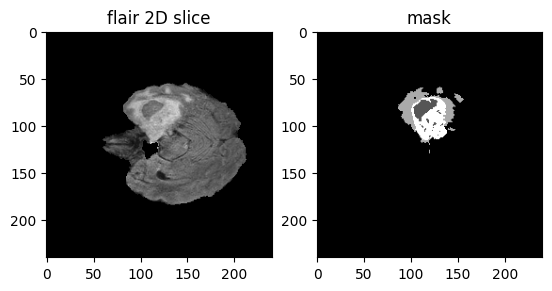

In [14]:
import random

idx = random.randint(0,154)
print(idx)

img =img_arr_list[idx]
mask = mask_arr_list[idx]
# img =np.expand_dims(img , axis =-1)
# print(np.shape(img))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title('flair 2D slice')
axarr[1].imshow(mask, cmap ='gray')
axarr[1].set_title('mask')


In [23]:
from sklearn import preprocessing as p

In [25]:
img_arr = np.array(img_arr_list)
np.shape(img_arr)
img_arr_norm =  (img_arr-np.min(img_arr))/(np.max(img_arr)-np.min(img_arr))

print(np.min(img_arr_norm), np.max(img_arr_norm))

0.0 1.0


In [31]:
bin_counts, bin_edges = np.histogram(img_arr_norm,bins=1, range=(0,1))

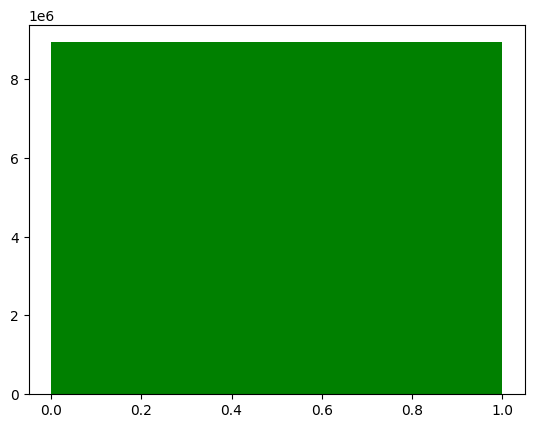

In [32]:


bin_counts, bin_edges, patches = plt.hist(img_arr_norm.ravel(), bins =1,color='green')

# FILTER empty slices:
**1.EDA. Find a range for threshold.** <br/>
**2.** SEG_LABEL = 0 : <br/>
&nbsp; SEG_LABEL = 1 <br/>
&nbsp; SEG_LABEL = 2 <br/>
&nbsp; SEG_LABEL = 3 <br/>
**3.Filter_Conditions:** <br/>
**a)Discard:** <br/>
slice-img that are **all black(0)** by comparing flair and it's segmentation mask.<br/>
**Condition:** if sum_of_all_pixel(flair) == 0 && sum_of_all_pixel(seg) == 0:<br/>
**output:** Elimninate these images as they have no information  <br/><br/>
**b)HGG or LGG:** <br/>
    if **mask contains class == 2 || class == 3** <br/>
    **-> then HGG or LGG** depending upon **name_mapping.csv**  <br/>
    **-> take the label from the csv file** <br/>
**c)Healthy:** <br/>
    if the **mask != [2,3]** i.e. **non-enhancing tumour** and **nunique_modularity != 0**<br/>
    **->** assign **label == Healthy**<br/>

# NPY file

In [9]:
DATASET_DIR =Path( '/home/shsingh/knowledge_distillation/knowledge_distillation/dataset/scratch')
dataset_name= 'MICCAI_BraTS20_trainigdata_npz'
meta_csv = 'name_mapping.csv'


dataset_dir = DATASET_DIR / dataset_name
#Load meta_csv from raw_data_dir
# naming_csv_path = dataset_dir  / str(meta_csv)

# df_name =  pd.read_csv(naming_csv_path)
# df_name =  df_name.drop(['BraTS_2017_subject_ID','BraTS_2018_subject_ID','TCGA_TCIA_subject_ID','BraTS_2019_subject_ID'], axis =1)
# df_name.head()


In [57]:
naming_csv_path ='/home/shsingh/knowledge_distillation/knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data/name_mapping.csv'
df_name =  pd.read_csv(naming_csv_path)

df_name =  df_name.drop(['BraTS_2017_subject_ID','BraTS_2018_subject_ID','TCGA_TCIA_subject_ID','BraTS_2019_subject_ID'], axis =1)
df_name.head()

,Grade,BraTS_2020_subject_ID
0,HGG,BraTS20_Training_001
1,HGG,BraTS20_Training_002
2,HGG,BraTS20_Training_003
3,HGG,BraTS20_Training_004
4,HGG,BraTS20_Training_005


In [58]:
survival_csv = '/home/shsingh/knowledge_distillation/knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_Data/survival_info.csv'
survival_df =  pd.read_csv(survival_csv)
survival_df.head()

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [59]:
survival_df['Extent_of_Resection'].value_counts()

GTR    119
STR     10
Name: Extent_of_Resection, dtype: int64

In [114]:
subject_ids = sorted(os.listdir(dataset_dir))
substring_subject_id ='BraTS20_'
#iterate over subjects
for subject in subject_ids:
    if substring_subject_id in subject:
        subject_path = dataset_dir / subject
        subject_modularities = sorted(os.listdir(subject_path))
        #iterate over each modularity of a subject
        for modularity in subject_modularities:
            if 'seg' in modularity:
                subject_seg_dir = subject_path / modularity                
                subject_seg_files = sorted(os.listdir(subject_seg_dir))
                #iterate over each seg_subject_file
                for file in subject_seg_files:
                    subject_seg_path = subject_seg_dir / file
                    image_id = str(subject_seg_path).split(".")[0]
                    subject_seg_path_str = str(subject_seg_path)
                    subject_flair_path = subject_seg_path_str.replace('seg', 'flair')
                    subject_t1_path = subject_seg_path_str.replace('seg', 't1')
                    subject_t1ce_path = subject_seg_path_str.replace('seg', 't1ce') 
                    subject_t2_path = subject_seg_path_str.replace('seg', 't2') 
                    print(subject_seg_path)
                    print(subject_flair_path)
                    print(subject_t1_path)
                    print(subject_t1ce_path)
                    print(subject_t2_path)
                    lbl_falir, lbl_t1, lbl_tce, lbl_t2 = get_all_mod_label(subject, subject_seg_path,subject_flair_path,
                                                                               subject_t1_path,subject_t1ce_path,
                                                                               subject_t2_path, df_name)
                    df_tmp = pd.DataFrame([(subject, image_id, lbl_falir, lbl_t1, lbl_tce, lbl_t2 )], 
                                          columns=['subject_id','image_id','label_flair','label_t1', 'label_t1ce', 'label_t2'])
                    map_df = map_df.append(df_tmp)    
                    break
                break
            break
        break
    break
        

                
                

In [115]:
map_df.head()

,subject_id,image_id,label_flair,label_t1,label_t1ce,label_t2
0,BraTS20_Training_001,/home/shsingh/knowledge_distillation/knowledge...,discard,discard,discard,discard
0,BraTS20_Training_002,/home/shsingh/knowledge_distillation/knowledge...,healthy,healthy,healthy,healthy
0,BraTS20_Training_003,/home/shsingh/knowledge_distillation/knowledge...,discard,discard,discard,discard
0,BraTS20_Training_004,/home/shsingh/knowledge_distillation/knowledge...,healthy,healthy,healthy,healthy
0,BraTS20_Training_005,/home/shsingh/knowledge_distillation/knowledge...,healthy,healthy,healthy,healthy


In [116]:
map_df['label_flair'].value_counts()

healthy    192
discard     78
Name: label_flair, dtype: int64

In [61]:
def get_all_mod_label(subject,seg_path, flair_path, t1_path, t1ce_path, t2_path, df_name):
    seg = np.load(seg_path)
    flair = np.load(flair_path)
    t1 = np.load(t1_path)
    t1ce = np.load(t1ce_path)
    t2 = np.load(t2_path)
    
    mod_list = [flair, t1, t1ce, t2]
    lbl_discard = 'discard'

    #Check if only  0's mod and seg
    if (np.sum(mod_list)) == 0: 
        return lbl_discard, lbl_discard, lbl_discard, lbl_discard
    else:
        flair_lbl = get_mod_label(subject, seg, flair, df_name)
        t1_lbl = get_mod_label(subject, seg, t1, df_name)
        t1ce_lbl = get_mod_label(subject, seg, t1ce, df_name)
        t2_lbl = get_mod_label(subject, seg, t2, df_name)
    return flair_lbl, t1_lbl, t1ce_lbl, t2_lbl
#         for mod in mod_list:
#             lbl = get_mod_label(subject, seg, mod, df_name)
    
    

In [113]:
def get_mod_label(subject, seg, mod, df_name):
    label = ""       
    #Check if HEALTHY. 
    #Healthy:if the seg != [2,3] i.e. non-enhancing tumour and nunique_modularity != 0 assign label == Healthy
    seg_unique = np.unique(seg)
    mod_unique = np.unique(mod)
    mod_sum = np.sum(mod)
    enhancing_seg_lbl = [2,3] #TODO: take this label as user input:: enhancing_seg_lbl
    non_enhancing_seg_lbl = [0,1] #TODO: take this label as user input::non_enhancing_seg_lbl
    if (mod_sum!=0 and (all(i not in  seg_unique for i in enhancing_seg_lbl))):
        return 'healthy'
    elif(mod_sum!=0 and (any(i in seg_unique for i in enhancing_seg_lbl))):
        label = df_name.loc[df_name['BraTS_2020_subject_ID']== subject]['Grade'].values[0]
        return label
         
        
    

In [53]:
a = [1, 2, 3, 4, 5]
b = [1, 2, 4]

print(all(i in a for i in b)) # Checks if all items are in the list
print(any(i in a for i in b)) 

z = (i in a for i in b)
z

True
True


<generator object <genexpr> at 0x7f9ef8fa6190>

# TEST: Map one subject samples to label w.r.t. csv

In [60]:
seg = np.load(dataset_dir / 'BraTS20_Training_001' / 'BraTS20_Training_001_seg' / 'BraTS20_Training_001_seg_100.npy' )
flair = np.load(dataset_dir / 'BraTS20_Training_001' / 'BraTS20_Training_001_flair' / 'BraTS20_Training_001_flair_100.npy')
t1 = np.load(dataset_dir / 'BraTS20_Training_001' / 'BraTS20_Training_001_t1' / 'BraTS20_Training_001_t1_100.npy')
t1ce = np.load(dataset_dir / 'BraTS20_Training_001' / 'BraTS20_Training_001_t1ce' / 'BraTS20_Training_001_t1ce_100.npy')
t2 = np.load(dataset_dir / 'BraTS20_Training_001' / 'BraTS20_Training_001_t2' / 'BraTS20_Training_001_t2_100.npy')


modularities_list = [flair, t1, t1ce, t2]

In [94]:
np.unique(np.load(seg))

array([0, 1, 2])

In [95]:
image_id = str(seg).split(".")[0]
image_id

'/home/shsingh/knowledge_distillation/knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_272/BraTS20_Training_272_seg/BraTS20_Training_272_seg_50'

In [117]:
seg = dataset_dir / 'BraTS20_Training_272' / 'BraTS20_Training_272_seg' / 'BraTS20_Training_272_seg_50.npy' 
flair = dataset_dir / 'BraTS20_Training_272' / 'BraTS20_Training_272_flair' / 'BraTS20_Training_272_flair_50.npy'
t1 = dataset_dir / 'BraTS20_Training_272' / 'BraTS20_Training_272_t1' / 'BraTS20_Training_272_t1_50.npy'
t1ce = dataset_dir / 'BraTS20_Training_272' / 'BraTS20_Training_272_t1ce' / 'BraTS20_Training_272_t1ce_50.npy'
t2 = dataset_dir / 'BraTS20_Training_272' / 'BraTS20_Training_272_t2' / 'BraTS20_Training_272_t2_50.npy'

subject = 'BraTS20_Training_272'

map_df = pd.DataFrame(columns=['subject_id','image_id','label_flair','label_t1', 'label_t1ce', 'label_t2'])

flair_lbl, t1_lbl, t1ce_lbl, t2_lbl = get_all_mod_label(subject,seg, flair, t1, t1ce, t2, df_name)
print(flair_lbl, t1_lbl, t1ce_lbl, t2_lbl )

LGG LGG LGG LGG


(240, 240, 1)

In [45]:
seg_li =[]
seg_p = str(dataset_dir / 'BraTS20_Training_001' / 'BraTS20_Training_001_seg' )
seg_fs = sorted(glob.glob(seg_p + '/**.npy', recursive=True))
for f in seg_fs:
    seg_li.append(np.load(f))
seg_li


[array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]]),
 array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
     

In [48]:
np.unique(seg_li)

array([0, 1, 2, 3])

In [8]:
dataset_dir

PosixPath('/home/shsingh/knowledge_distillation/knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz')

### Image

In [69]:
path = "knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData_2D/"

naming_csv_path ='knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv'
df_name =  pd.read_csv(naming_csv_path)
df_name =  df_name.drop(['BraTS_2017_subject_ID','BraTS_2018_subject_ID','TCGA_TCIA_subject_ID','BraTS_2019_subject_ID'], axis =1)



FileNotFoundError: [Errno 2] No such file or directory: 'knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv'

In [ ]:
map_df = pd.DataFrame(columns=['BraTS_2020_subject_ID','image_name','label'])

In [ ]:
 def create_mapping_csv(data_path):
        
        map_df = pd.DataFrame(columns=['BraTS_2020_subject_ID','image_name','label'])
        patient_ids = os.listdir(path)
        

        for pat_id in patient_ids:
        #     print(pat_id)
            flair_path = os.path.join(path, pat_id,pat_id+ "_flair")
            seg_path = os.path.join(path, pat_id,pat_id+ "_seg")
            flair_path = flair_path.replace("\\",'/')
            seg_path = seg_path.replace("\\",'/')

            print(flair_path)
            print(seg_path)
            
            flair_dir = os.listdir(flair_path)
            
             for img_name in  flair_dir:
                    
                    
            #         map_df['BraTS_2020_subject_ID'] = pat_id
                    print("name:",img_name)
            #         map_df['image_name'] =img_name
                    seg_name = img_name.replace("flair","seg")
                    print(seg_name)
                    
                    flair_img = np.load(os.path.join(flair_path,img_name ))
                    seg_img = np.load(os.path.join(seg_path,seg_name))

#                     flair_img = cv.imread(os.path.join(flair_path,img_name ))
#                     seg_img = cv.imread(os.path.join(seg_path,seg_name ))
                    
                    print(np.unique(flair_img))
                    print("SHAPE of FLAIR :", np.shape(flair_img))

                    print("SHAPE of SEG :", np.shape(seg_img))
                    unq_seg = np.unique(seg_img)
                    print(unq_seg)

                    flair_sum = np.sum(flair_img)
                    seg_sum = np.sum(seg_img)                    

                    #1. Discard slice-img that are all black(0) by comparing flair and it's segmentation mask
                    # Condition: if sum_of_all_pixel(flair) == 0 && sum_of_all_pixel(seg) == 0:
                    # output: Elimninate these images as they have no information
                    #break
                    if (flair_sum == 0 and seg_sum ==0 ):
                        label = 'discard'
            #             map_df['label'] = 'discard'

                    #2. if mask contains class==2 || class==3
                    #   then HGG or LGG depending upon name_mapping.csv
                    # take the label from the csv file 
                    elif( all(x in unq_seg for x in [85, 170])):
                        label = df_name.loc[df_name['BraTS_2020_subject_ID']== pat_id]['Grade'].values[0]
            #             map_df['label'] = df_name.loc[df_name['BraTS_2020_subject_ID']== pat_id]['Grade']

                    #. Healthy: if the mask != [2,3] i.e. non-enhancing tumour and nunique_flair != 0
                    # assign label == Healthy
                    elif (flair_sum != 0 and 170 not in unq_seg and 85 not in unq_seg):
                        label = 'healthy'
            #             map_df['label'] = 'healthy'

                    df_tmp = pd.DataFrame([(pat_id, img_name, label)], columns=["BraTS_2020_subject_ID", "image_name", "label"])
                    map_df = map_df.append(df_tmp)    




In [ ]:
#FILTER all 4 modularities: T1, T2, T1CE, FLAIR w.r.t seg_mask

In [ ]:

map_df = pd.DataFrame(columns=['BraTS_2020_subject_ID','image_name','label'])

patient_ids = os.listdir(path)


for pat_id in patient_ids:
#     print(pat_id)
    flair_path = os.path.join(path, pat_id,pat_id+ "_flair")
    seg_path = os.path.join(path, pat_id,pat_id+ "_seg")
    flair_path = flair_path.replace("\\",'/')
    seg_path = seg_path.replace("\\",'/')
    
    print(flair_path)
    print(seg_path)
   
    
    
    flair_dir = os.listdir(flair_path)
    
    for img_name in  flair_dir:
#         map_df['BraTS_2020_subject_ID'] = pat_id
        print("name:",img_name)
#         map_df['image_name'] =img_name
        seg_name = img_name.replace("flair","seg")
        print(seg_name)
        
        flair_img = cv.imread(os.path.join(flair_path,img_name ))
        seg_img = cv.imread(os.path.join(seg_path,seg_name ))
        print(np.unique(flair_img))
        print("SHAPE of FLAIR :", np.shape(flair_img))
        
        print("SHAPE of SEG :", np.shape(seg_img))
        unq_seg = np.unique(seg_img)
        print(unq_seg)
        
        flair_sum = np.sum(flair_img)
        seg_sum = np.sum(seg_img)                    
            
        #1. Discard slice-img that are all black(0) by comparing flair and it's segmentation mask
        # Condition: if sum_of_all_pixel(flair) == 0 && sum_of_all_pixel(seg) == 0:
        # output: Elimninate these images as they have no information
        #break
        if (flair_sum == 0 and seg_sum ==0 ):
            label = 'discard'
#             map_df['label'] = 'discard'
        
        #2. if mask contains class==2 || class==3
        #   then HGG or LGG depending upon name_mapping.csv
        # take the label from the csv file 
        elif( all(x in unq_seg for x in [85, 170])):
            label = df_name.loc[df_name['BraTS_2020_subject_ID']== pat_id]['Grade'].values[0]
#             map_df['label'] = df_name.loc[df_name['BraTS_2020_subject_ID']== pat_id]['Grade']
                     
        #. Healthy: if the mask != [2,3] i.e. non-enhancing tumour and nunique_flair != 0
        # assign label == Healthy
        elif (flair_sum != 0 and 170 not in unq_seg and 85 not in unq_seg):
            label = 'healthy'
#             map_df['label'] = 'healthy'

        df_tmp = pd.DataFrame([(pat_id, img_name, label)], columns=["BraTS_2020_subject_ID", "image_name", "label"])
        map_df = map_df.append(df_tmp)    
        
            
map_csv = map_df.to_csv('/home/shsingh/knowledge_distillation/knowledge_distillation/dataset/scratch/mapping.csv', sep='\t', )
            
        
        
        

        
map_df      
 
    

In [ ]:
map_df